**1. Import libraries :**

In [ ]:
!pip install opendatasets

import opendatasets as od

od.download("https://www.kaggle.com/datasets/zssash/zarasl-database-54k")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rahaf8
Your Kaggle Key: ··········


100%|██████████| 65.1M/65.1M [00:00<00:00, 89.4MB/s]


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from time import perf_counter
import seaborn as sns
import random as rn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
import sklearn.metrics as metrics
from IPython.display import Markdown, display
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import GridSearchCV 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from collections import defaultdict
from tensorflow.compat.v1.keras import backend as K

def printmd(string):
    display(Markdown(string))

import warnings
warnings.filterwarnings("ignore")

In [ ]:
seed_num = 1
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

**2. Load Data :**


In [ ]:
# load Class Labels 
classes = pd.read_excel("ClassLabels.xlsx")
display(classes.head())

,ClassId,Class,ClassAr
0,0,ain,عين
1,1,al,ال
2,2,aleff,الف
3,3,bb,باء
4,4,dal,دال


In [ ]:
imagePath = pd.DataFrame(columns=['ClassId','ImagePath'])

classeList = list(classes['Class'])

pathlist = []
for c in classeList :
    for dirname, _, filenames in os.walk('ArASL_Database_54K/'+c):
        for name in filenames:
           imagePath =  imagePath.append({'ClassId': c, 'ImagePath': dirname+'/'+name}, ignore_index=True)
imagePath.head()         

,ClassId,ImagePath
0,ain,ArASL_Database_54K/ain/AIN (917).JPG
1,ain,ArASL_Database_54K/ain/AIN (10).JPG
2,ain,ArASL_Database_54K/ain/AIN (1841).jpg
3,ain,ArASL_Database_54K/ain/AIN (1490).jpg
4,ain,ArASL_Database_54K/ain/AIN (888).JPG


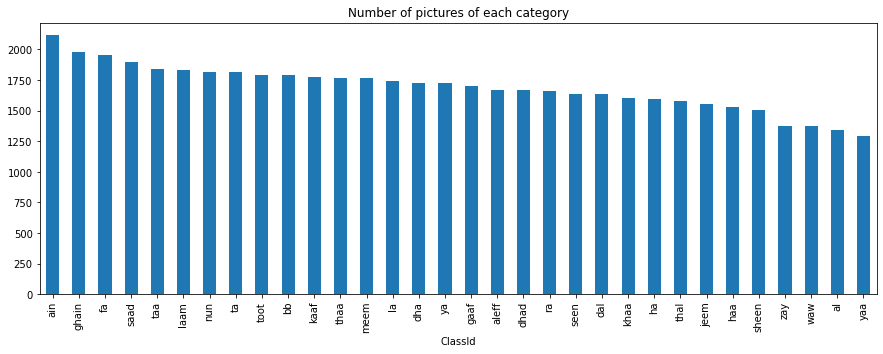

In [ ]:
imagePath.groupby("ClassId").size().sort_values(ascending=False).plot.bar(title='Number of pictures of each category',figsize=(15,5))
plt.show()

**3. Define Functions :**


In [ ]:
def SplitData(testsize, dataSample):
    df = imagePath.sample(frac = dataSample)
    min = df.groupby("ClassId").size().min()
    print('{0} Samples per Class'.format(min))
    
    df_TrainingSet = df[0:0].copy()
    df_TestSet = df[0:0].copy()

    for index,row in classes.iterrows():
        df_FullSet = df[df['ClassId'] == row['Class']].sample(min,random_state= 42)
        
        trainingSet, testSet = train_test_split(df_FullSet, test_size= testsize)        
        
        df_TrainingSet = df_TrainingSet.append(trainingSet)
        df_TestSet = df_TestSet.append(testSet)   

    df_TrainingSet = df_TrainingSet.sample(frac = 1)
    df_TestSet = df_TestSet.sample(frac = 1)
    
    return df_TrainingSet,df_TestSet

In [146]:
# Load the Images with a generator and Data Augmentation
def create_gen(modelType):
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=eval('tf.keras.applications.'+modelType.lower()+'.preprocess_input'),
        validation_split=0.2
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=eval('tf.keras.applications.'+modelType.lower()+'.preprocess_input'),
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='ImagePath',
        y_col='ClassId',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        shuffle=True,
        seed=seed_num,
        subset='training',
        batch_size = 64,
        
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='ImagePath',
        y_col='ClassId',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        shuffle=True,
        seed=seed_num,
        subset='validation',
        batch_size = 64,
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='ImagePath',
        y_col='ClassId',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False,
        batch_size = 64,
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [164]:
def get_model(model):
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg',
                #'dropout':0.01
                 }
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(32, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

**4. Choose the best CNN Model architecture  :**

4a. Preparing Data :

In [161]:
#SplitData(0.2,0.1) -> take a 30% random sample from the dataset and split it into 80% training and 10% validation and 10% testing 
train_df, test_df = SplitData(0.2,0.1) 
print('Training {} \t # {} per class'.format(train_df.shape[0], train_df.shape[0] //32))
print('Test     {} \t # {} per class'.format(test_df.shape[0], test_df.shape[0] //32))
print('---------------')
print('Sum      {}'.format(train_df.shape[0] + test_df.shape[0]))

112 Samples per Class
Training 2848 	 # 89 per class
Test     736 	 # 23 per class
---------------
Sum      3584


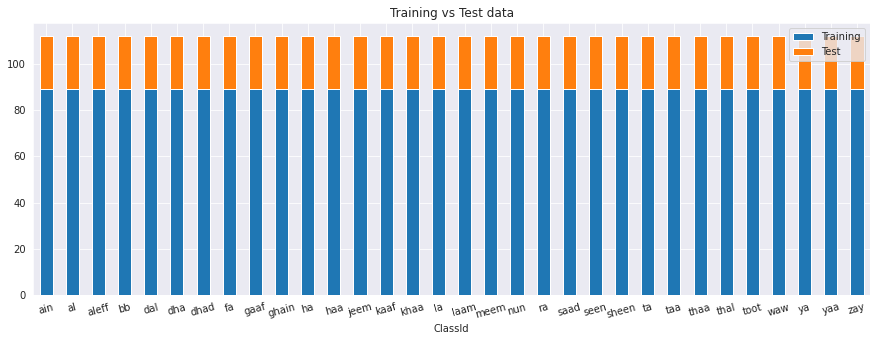

In [162]:
ddata = {"Training":train_df.groupby("ClassId").size(),"Test":test_df.groupby("ClassId").size()}

ddataframe = pd.DataFrame(data=ddata)
ddataframe.plot.bar(stacked= True, rot= 15, title='Training vs Test data',figsize=(15,5))
plt.show(block= True)

4b.Test canned architectures with pre-trained weights with A random 20% sample of the DataFrame:

In [165]:
models = {
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0 ,"input":"MobileNet"},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0, "input":"MobileNet_V2"},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0, "input":"MobileNet_V3"},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0, "input":"MobileNet_V3"},
}

# note : the image shape "64x64" was chosen after trying several image dimensions, and we chose the one with the highest accuracy.    


for name, model in models.items():
    print("Model: ",name," : ")
    print("Image shape: 64x64")

    train_generator,test_generator,train_images,val_images,test_images=create_gen(model['input'])
    print('\n')
        
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m 
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=2,verbose=1)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    print('model accurcy: ',models[name]['val_acc'])
    print('\n')  

Model:  MobileNet  : 
Image shape: 64x64
Found 2279 validated image filenames belonging to 32 classes.
Found 569 validated image filenames belonging to 32 classes.
Found 736 validated image filenames belonging to 32 classes.


Epoch 1/2
36/36 [==============================] - 6s 124ms/step - loss: 2.7715 - accuracy: 0.2558 - val_loss: 1.7890 - val_accuracy: 0.4991
Epoch 2/2
36/36 [==============================] - 4s 108ms/step - loss: 1.2076 - accuracy: 0.6534 - val_loss: 0.9984 - val_accuracy: 0.7188
MobileNet            trained in 11.21 sec
model accurcy:  [0.4991, 0.7188]


Model:  MobileNetV2  : 
Image shape: 64x64
Found 2279 validated image filenames belonging to 32 classes.
Found 569 validated image filenames belonging to 32 classes.
Found 736 validated image filenames belonging to 32 classes.


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/2
36/36 [==============================] - 9s 160ms/step - loss: 2.7704 - accuracy: 0.2273 - val_loss: 1.8878 - va

In [166]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_acc','Training time (sec)'])
df_results.sort_values(by='val_acc', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_acc,Training time (sec)
0,MobileNet,0.7188,11.21
1,MobileNetV2,0.6221,13.95
2,MobileNetV3Large,0.6151,14.17
3,MobileNetV3Small,0.5395,11.42


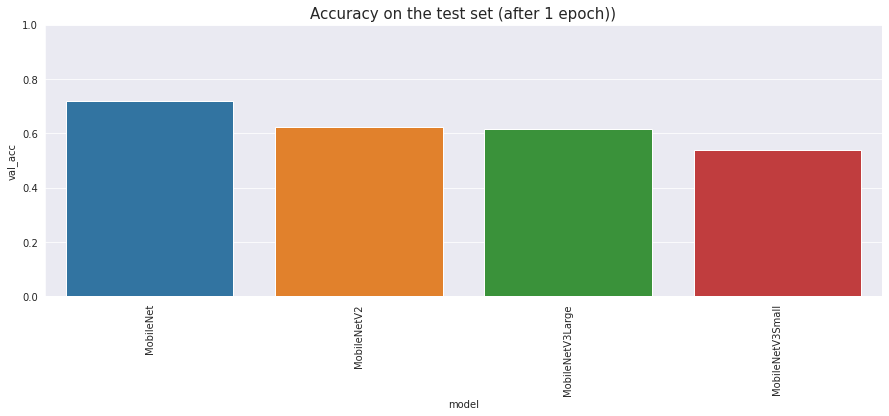

In [167]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_acc', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

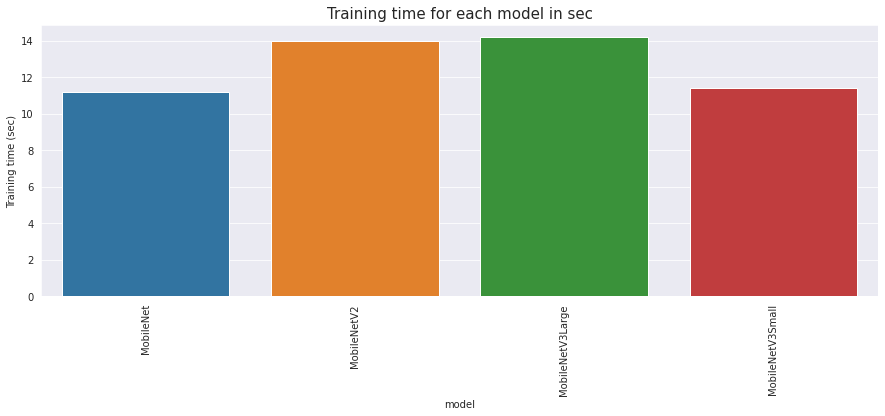

In [168]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

**5. Train the CNN model with the best result using the whole dataset :**  

5a. Preparing Data :

In [ ]:
#SplitData(0.1,0.2) ->split the whole dataset split it into 90% training and 10% testing 
train_df, test_df = SplitData(0.2,1)
print('Training {} \t # {} per class'.format(train_df.shape[0], train_df.shape[0] //32))
print('Test     {} \t # {} per class'.format(test_df.shape[0], test_df.shape[0] //32))
print('---------------')
print('Sum      {}'.format(train_df.shape[0] + test_df.shape[0]))

1293 Samples per Class
Training 33088 	 # 1034 per class
Test     8288 	 # 259 per class
---------------
Sum      41376


5b. train model :

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
model = get_model(eval('tf.keras.applications.MobileNet'))

In [151]:
model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                   

In [152]:
train_generator,test_generator,train_images,val_images,test_images=create_gen('MobileNet')

history = model.fit(train_images,
                    validation_data=val_images,
                    batch_size=64,
                    epochs=6,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True), 
                        ModelCheckpoint(filepath='letter_model.h5', monitor='val_loss', save_best_only= True)
                        ])                        

Found 26471 validated image filenames belonging to 32 classes.
Found 6617 validated image filenames belonging to 32 classes.
Found 8288 validated image filenames belonging to 32 classes.
Epoch 1/6
414/414 [==============================] - 47s 110ms/step - loss: 0.7494 - accuracy: 0.7866 - val_loss: 0.2531 - val_accuracy: 0.9275
Epoch 2/6
414/414 [==============================] - 45s 108ms/step - loss: 0.1845 - accuracy: 0.9487 - val_loss: 0.1709 - val_accuracy: 0.9504
Epoch 3/6
414/414 [==============================] - 45s 108ms/step - loss: 0.1114 - accuracy: 0.9695 - val_loss: 0.1301 - val_accuracy: 0.9651
Epoch 4/6
414/414 [==============================] - 45s 109ms/step - loss: 0.0771 - accuracy: 0.9779 - val_loss: 0.1272 - val_accuracy: 0.9642
Epoch 5/6
414/414 [==============================] - 45s 108ms/step - loss: 0.0568 - accuracy: 0.9839 - val_loss: 0.0999 - val_accuracy: 0.9736
Epoch 6/6
414/414 [==============================] - 44s 107ms/step - loss: 0.0453 - accuracy

In [153]:
!tflite_convert \
  --keras_model_file=letter_model.h5 \
  --output_file=letter_model.tflite

2022-11-01 01:51:27.414537: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-01 01:51:37.580844: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 512.0KiB (rounded to 524288)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-01 01:51:37.581082: W tensorflow/core/common_runtime/bfc_allocator.cc:491] ********______*****______***************************************************________________________
2022-11-01 01:51:37.581174: W tensorflow/core/framework/op_kernel.cc:1733] RESOURCE_EXHAUSTED: failed to allocate memory
Traceback (most recent call last):
  File "/usr/local/bin/tflite_convert", line 8, 

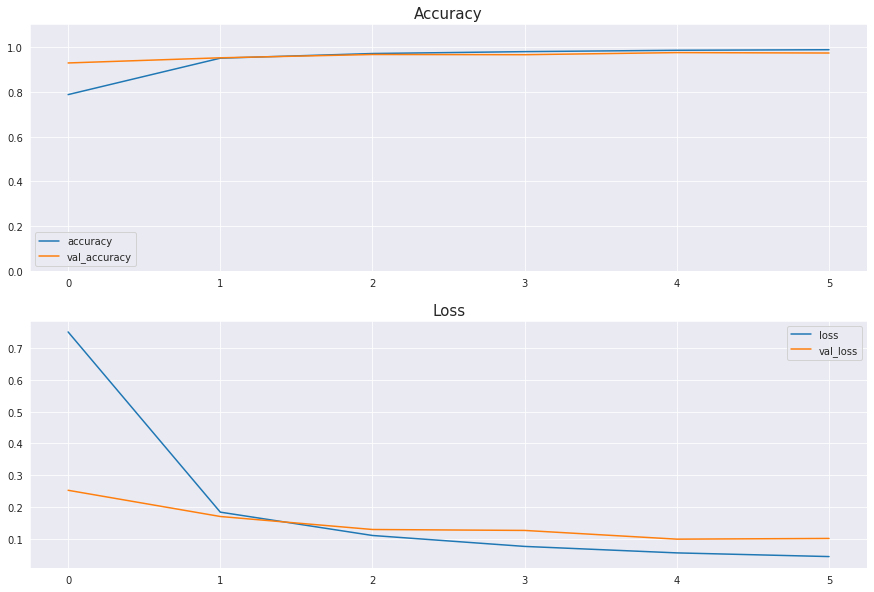

In [154]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

**7. Test the architecture with the best result using the whole dataset :**

In [155]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.ClassId)

130/130 [==============================] - 12s 88ms/step


**8. Evaluation metrics  :**

8a.Accuracy :

In [156]:
print(f'MobileNet Model accuracy on the test set is : {accuracy_score(y_test,pred)*100:.2f}%')

MobileNet Model accuracy on the test set is : 97.55%


8b.Confusion Matrix :

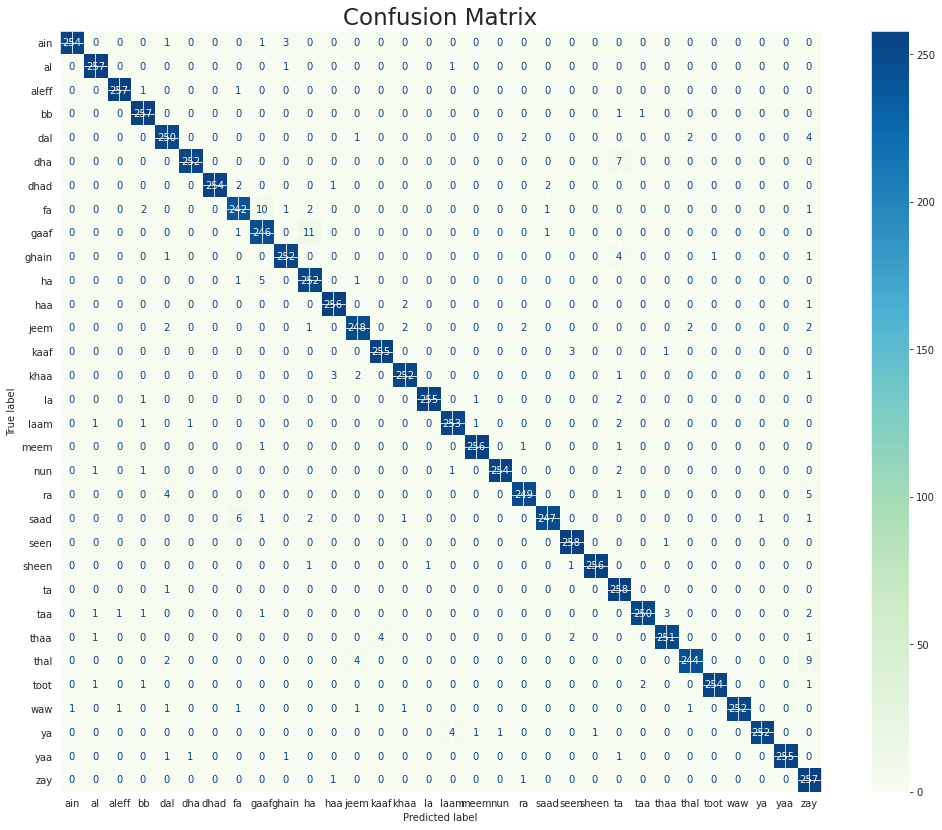

In [157]:
fig, ax = plt.subplots(figsize=(18, 14))
cm = confusion_matrix(y_test, pred,)
cmp = ConfusionMatrixDisplay(cm, display_labels=classes['Class'])
cmp.plot(ax=ax,cmap=plt.cm.GnBu)
plt.title('Confusion Matrix', fontsize = 23)
plt.show();

8c.Classification report :

MobileNet Model F1 score on the test set is : 97.56%
MobileNet Model Recall score on the test set is : 97.55%
MobileNet Model Precision score on the test set is : 97.61%


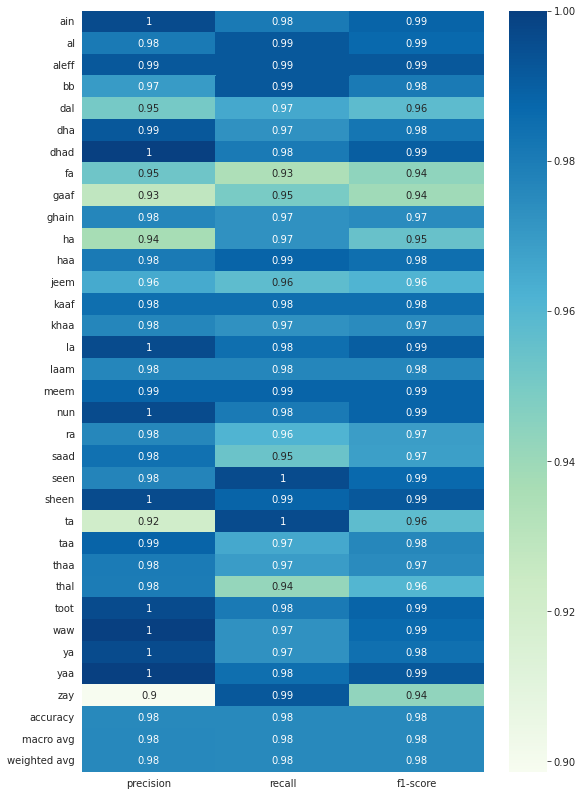

In [158]:
print(f'MobileNet Model F1 score on the test set is : {(metrics.f1_score(y_test,pred,average="macro"))*100:.2f}%')
print(f'MobileNet Model Recall score on the test set is : {metrics.recall_score(y_test,pred,average="macro")*100:.2f}%')
print(f'MobileNet Model Precision score on the test set is : {metrics.precision_score(y_test,pred,average="macro")*100:.2f}%')

clf_report = classification_report(y_test,
                                   pred,
                                   target_names=classes['Class'],
                                   output_dict=True,
                                   digits=3)
fig, ax = plt.subplots(figsize=(9,14))                                      
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap=plt.cm.GnBu)                                  

8e.Area under the ROC :

MobileNet Model ROC AUC score on the test set is : 98.74%


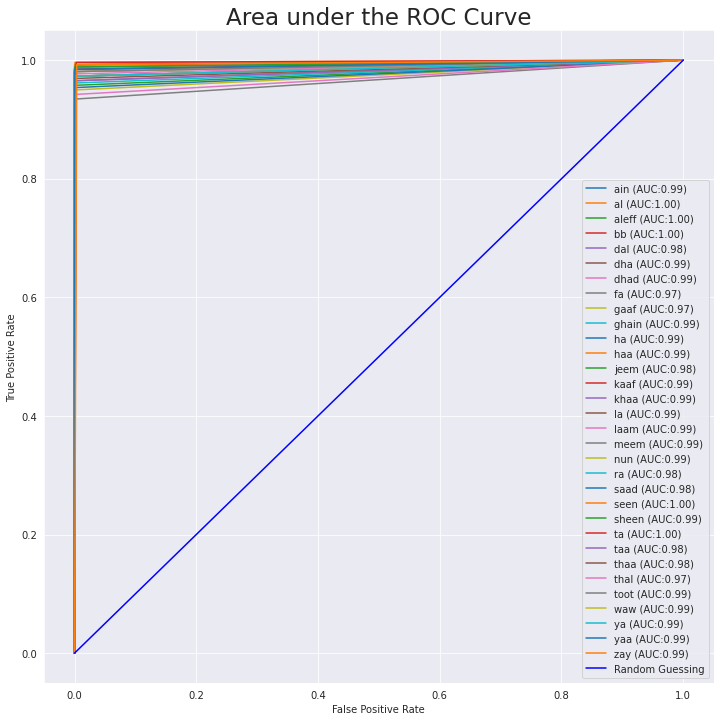

In [159]:
target= classes['Class']
fig, c_ax = plt.subplots(1,1, figsize = (12, 12))

def multiclass_roc_auc_score(test, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(test)
    test = lb.transform(test)
    pred = lb.transform(pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(test[:,idx].astype(int), pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(test, pred, average=average)

print(f'MobileNet Model ROC AUC score on the test set is : { multiclass_roc_auc_score(y_test, pred)*100:.2f}%')
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.title('Area under the ROC Curve', fontsize = 23)
plt.show()

**9. Examples of prediction :**

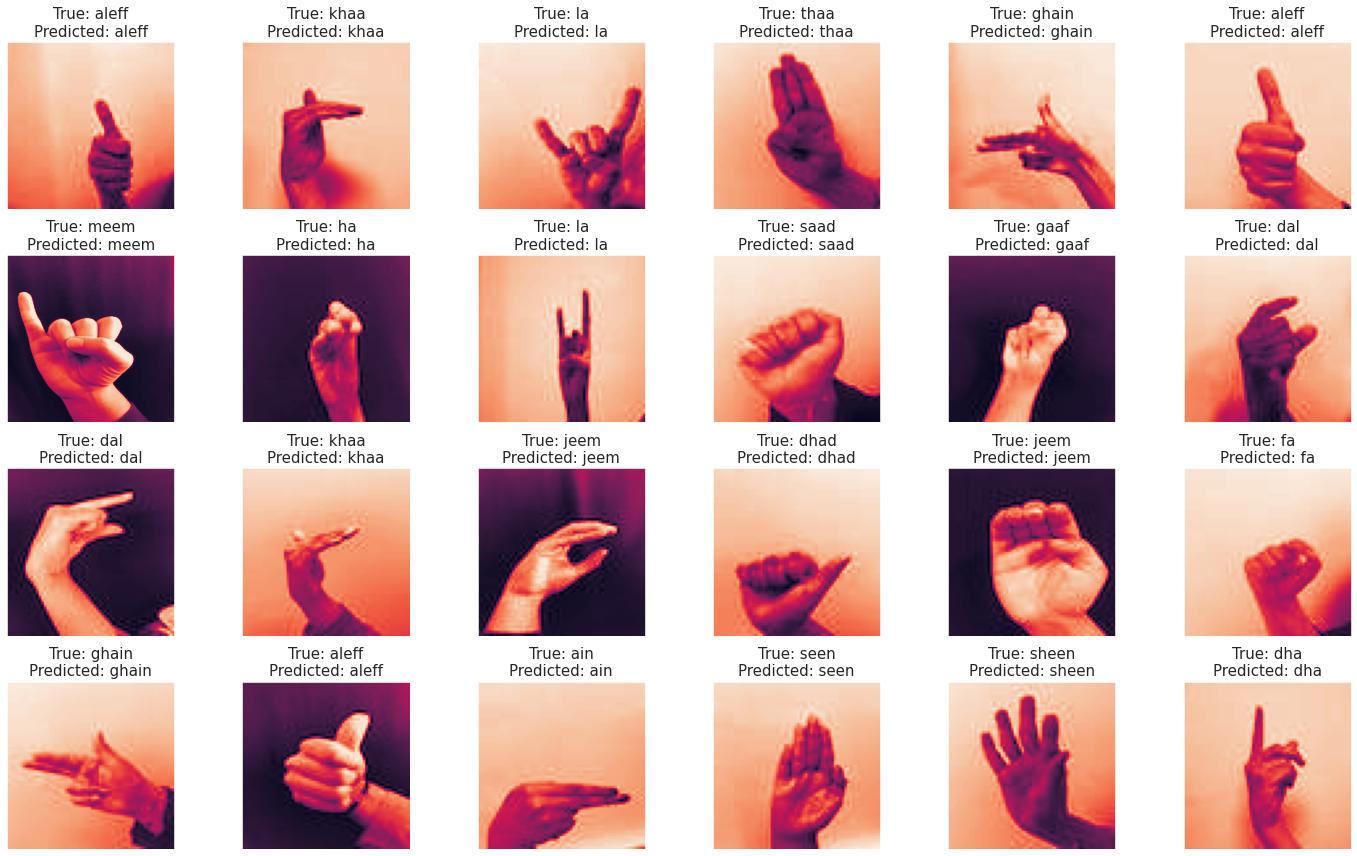

In [160]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.ImagePath.iloc[i]))
    ax.set_title(f"True: {test_df.ClassId.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()